In [1]:
import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from lanczos import lanczos_algorithm, process_adjacency_matrix
from pygcn.pygcn.utils import load_data, encode_onehot, normalize, accuracy
from nn.layers import SpectralConv, ExpKernel
from pygcn.pygcn.layers import GraphConvolution

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)

# Quora citation dataset

## Data processing

In [2]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path = 'pygcn/data/cora/')
A = adj.detach().to_dense().numpy()

Loading cora dataset...


In [3]:
A.sum(0)[:15]

array([0.8333334 , 0.53125   , 0.52758074, 0.78333336, 0.8333334 ,
       0.625     , 0.5694444 , 0.5833333 , 0.8000001 , 1.2416667 ,
       0.7519842 , 0.61904764, 0.61025643, 0.7166667 , 4.8333335 ],
      dtype=float32)

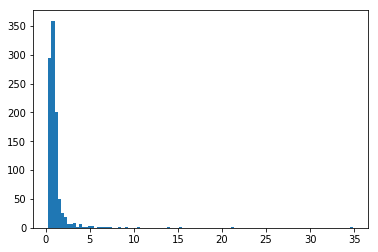

In [4]:
plt.hist(A.sum(0)[:1000], bins=100)
plt.show()

Looks like A is already normalized, and diagonal elements are nonzero. Maybe, we don't even need to calculate S? <br>
UPD. A is slightly worse then S: max accuracy 84.6 in comparison to 84.  

In [5]:
k=10
S, V, R = process_adjacency_matrix(A, k) #need only this one
# S, Q, T = process_adjacency_matrix(A, k, ritz=False)

100%|██████████| 10/10 [00:00<00:00, 27.49it/s]


NameError: name 'T' is not defined

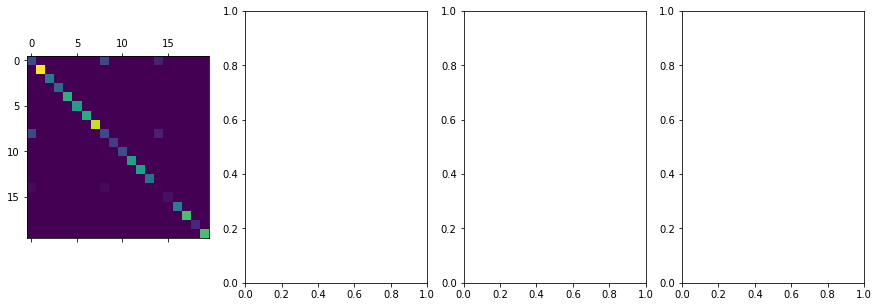

In [6]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
m1 = ax1.matshow(S[:20,:20])
m2 = ax2.matshow(T[:20,:20])
m3 = ax3.matshow((Q@T@Q.T)[:20,:20])
m4 = ax4.matshow((V@R@V.T)[:20,:20])
f.colorbar(m1, ax=ax1)
f.colorbar(m2, ax=ax2)
f.colorbar(m3, ax=ax3)
f.colorbar(m4, ax=ax4)

## Training

In [6]:
class LanczosConvNet(nn.Module):
    def __init__(self, k, feat_dim, spectral_features, num_classes, short_scales, long_scales, conv_dim):
        super(LanczosConvNet, self).__init__()
        super().__init__()
        spectral_conv_params = {
            'in_features': feat_dim,
            'out_features': spectral_features,
#             'out_features': num_classes,
            'k': k,
            'short_scales': short_scales,
            'long_scales': long_scales,
            'mlp_layers_number': 3
        }
        spectral_conv2_params = {
            'in_features': spectral_features,
#             'out_features': spectral_features // 2,
            'out_features': num_classes,
            'k': k,
            'short_scales': short_scales,
            'long_scales': long_scales,
            'mlp_layers_number': 3
        }
        self.spectral_conv = SpectralConv(**spectral_conv_params)
#         self.spectral_conv2 = SpectralConv(**spectral_conv2_params)
#         self.mlp = nn.Sequential(nn.Linear(spectral_features // 2, spectral_features // 4),
#                                  nn.Linear(spectral_features // 4, num_classes))
        self.mlp = nn.Sequential(nn.Linear(spectral_features, spectral_features // 2),
                                 nn.Linear(spectral_features // 2, num_classes))
#         self.conv1 = GraphConvolution(spectral_features, conv_dim)
#         self.conv2 = GraphConvolution(conv_dim, num_classes)
                                      
    def forward(self, adj, X, S, V, R):
        Z = self.spectral_conv(X, S, V, R)
#         Z = self.spectral_conv2(Z, S, V, R)
        Z = self.mlp(Z)
        return F.log_softmax(Z)
#         Z = self.conv1(features, adj)
#         Z = self.conv2(Z, adj)        
        
#         return F.log_softmax(Z)

In [7]:
n = adj.shape[0]
feat_dim = 1433
conv_dim = 256
short_scales = [1, 3, 5]
long_scales = [10,20,30]
num_classes = 7
lr = 1e-2

In [8]:
# A = torch.Tensor(A).cuda()
X = features.requires_grad_().cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(np.diag(R)).cuda()
labels = labels.cuda()
model = None

In [9]:
loss_train_vals = []
loss_test_vals = []
acc_train_vals = []
acc_test_vals = []

kernel = ExpKernel(X, A, [feat_dim // 2, feat_dim // 4], e=1000, learn_embeddings=True).cuda()
model = LanczosConvNet(k, feat_dim, feat_dim // 4, num_classes, short_scales, long_scales, conv_dim).cuda()
optimizer = optim.Adam(list(model.parameters()) + list(kernel.parameters()), lr=lr)

def train(epoch, eval_epoch=3):
    A = kernel(X)
    S, V, R = process_adjacency_matrix(A, k, ritz=False)
    if type(S) != torch.Tensor:
        S = torch.Tensor(S).cuda()
#     S = S.cuda()
    V = torch.Tensor(V).cuda()
    w = torch.Tensor(np.diag(R)).cuda()
#     print(A, S)
    
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    kernel.X.grad.data.clamp_(-1, 1)
    optimizer.step()

    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    loss_train_vals.append(loss_train.item())
    loss_test_vals.append(loss_val.item())
    acc_train_vals.append(acc_train.item())
    acc_test_vals.append(acc_val.item())
    
    if epoch > 0 and epoch%eval_epoch == 0:
        clear_output()
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(loss_train_vals, label='train')
        ax1.plot(loss_test_vals, label='test')
        ax1.set_title('loss')
        ax1.legend()
        
        ax2.plot(acc_train_vals, label='train')
        ax2.plot(acc_test_vals, label='test')
        ax2.set_title('accuracy')
        ax2.legend()
        
        plt.show()
        
        print('Epoch: \t{:04d}\n'.format(epoch+1),
              'loss_train: \t{:.4f}\n'.format(loss_train_vals[-1]),
              'acc_train: \t{:.4f}\n'.format(acc_train_vals[-1]),
              'loss_val: \t{:.4f}\n'.format(loss_test_vals[-1]),
              'acc_val: \t{:.4f}\n'.format(acc_test_vals[-1]))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

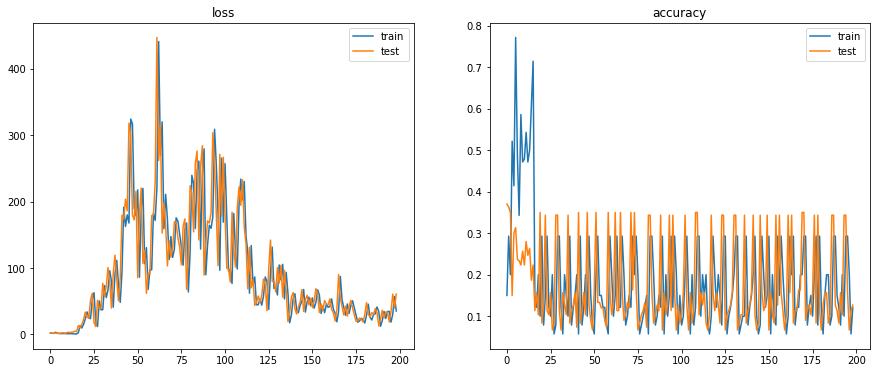

 20%|██        | 2/10 [00:00<00:00, 18.60it/s]

Epoch: 0199 loss_train: 35.3268 acc_train: 0.1214 loss_val: 60.7495 acc_val: 0.1267


100%|██████████| 10/10 [00:00<00:00, 18.94it/s]




min test loss: 	11.850515365600586
max test accuracy: 	0.37000000000000005


In [10]:
epochs=200
for epoch in tqdm(range(epochs)):
    train(epoch)
print(f'\nmin test loss: \t{loss_test_vals[np.argmin(acc_test_vals)]}')
print(f'max test accuracy: \t{max(acc_test_vals)}')

In [12]:
(X.cpu().detach().numpy() == features.detach().numpy()).sum()/X.shape[0]/X.shape[1]

0.0